In [1]:
from clean_parent import clean_parent, clean_child
from parent_pca import pca_parent_lowrank_approx
from velocity import fit_spline_with_velocity
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import optuna
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [17]:
path = "../adv-ml-2025/gen1_train_comp_final.csv"
parent_wide, parent_long = clean_parent(path)

path = "../adv-ml-2025/gen2_train_comp_final.csv"
child_wide, child_long, child2parent, parent2sex, child2sex = clean_child(path)

In [18]:
child_wide = child_wide.rename(columns={k:"child_"+str(k) for k in child_wide.columns})
parent_wide = parent_wide.rename(columns={k:"parent_"+str(k) for k in parent_wide.columns})

In [19]:
child_wide.loc[:, "sex"] = child_wide.index.map(child2sex)
child_wide.loc[:, "gen1_id"] = child_wide.index.map(child2parent)
child_wide.loc[:, "parent_sex"] = child_wide.loc[:, "gen1_id"].map(parent2sex)

In [20]:
merged_df = child_wide.merge(
    parent_wide, left_on="gen1_id", right_index=True, how="left"
).dropna()

In [21]:
merged_df.head()

,child_0.1,child_0.25,child_0.5,child_0.75,child_1.0,child_1.5,child_2.0,child_3.0,child_4.0,child_5.0,...,parent_15.5,parent_16.0,parent_16.5,parent_17.0,parent_17.5,parent_18.0,parent_18.5,parent_19.0,parent_19.5,parent_20.0
gen2_id,,,,,,,,,,,,,,,,,,,,,
2509,58.340287,64.892308,69.872290,74.645393,77.889181,85.099498,90.794792,100.800558,109.603019,114.060892,...,184.158103,185.352121,186.178159,186.566052,187.010304,187.320811,187.306432,187.292054,187.700016,188.107978
2510,60.230630,66.481798,72.892351,75.839962,79.379582,85.720324,94.149611,102.995835,111.842058,117.804483,...,192.473030,194.305717,194.453334,194.755102,194.676736,194.970999,195.092417,195.213834,195.464294,195.714755
2513,52.931457,60.670300,67.657720,72.429313,77.864908,84.589526,88.423925,96.628471,103.676850,108.883130,...,172.912806,175.870532,179.276514,180.730152,182.141760,182.991174,183.055302,184.778050,184.384969,185.051548
2514,59.747495,67.777098,73.293031,78.117079,81.205328,89.445960,96.569437,105.724538,114.287340,120.079372,...,173.165838,174.747713,179.356033,182.232486,186.965840,188.761179,189.732545,191.797827,192.428120,193.183434
2515,57.874021,66.271674,71.975038,74.358996,81.091844,87.847264,97.178483,106.509702,113.283472,119.793981,...,180.230267,184.040152,186.571063,187.859403,189.477404,189.772037,189.939614,190.502810,191.041194,191.686232


In [30]:
X = merged_df.iloc[:, -36:]
y = merged_df["child_18.0"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

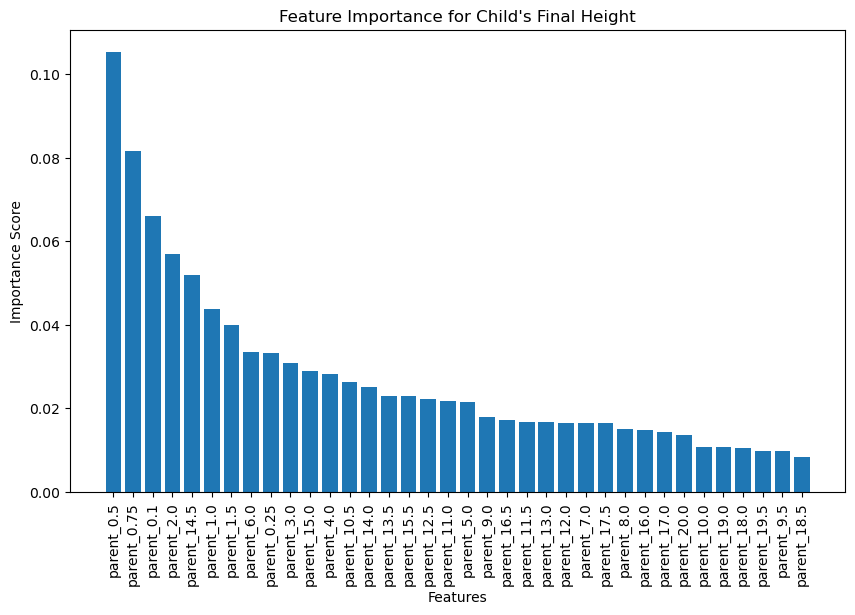

In [31]:
# Train a RandomForest model
rf_model = RandomForestRegressor(n_estimators=500, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance scores
feature_importance = rf_model.feature_importances_

# Plot feature importance
features = X_train.columns
indices = np.argsort(feature_importance)[::-1]  # Sort in descending order

plt.figure(figsize=(10, 6))
plt.bar(range(len(features)), feature_importance[indices], align="center")
plt.xticks(range(len(features)), np.array(features)[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.title("Feature Importance for Child's Final Height")
plt.show()

In [32]:
xgb_model = XGBRegressor(n_estimators=500, random_state=42)
xgb_model.fit(X_train, y_train)

# Get importance scores
xgb_importance = xgb_model.feature_importances_

# Display top features
sorted_indices = np.argsort(xgb_importance)[::-1]
for i in sorted_indices[:10]:  # Show top 10 features
    print(f"{X_train.columns[i]}: {xgb_importance[i]:.4f}")

parent_11.0: 0.1703
parent_18.5: 0.1696
parent_15.5: 0.1081
parent_14.5: 0.0864
parent_17.0: 0.0601
parent_14.0: 0.0423
parent_11.5: 0.0417
parent_6.0: 0.0386
parent_8.0: 0.0328
parent_15.0: 0.0251


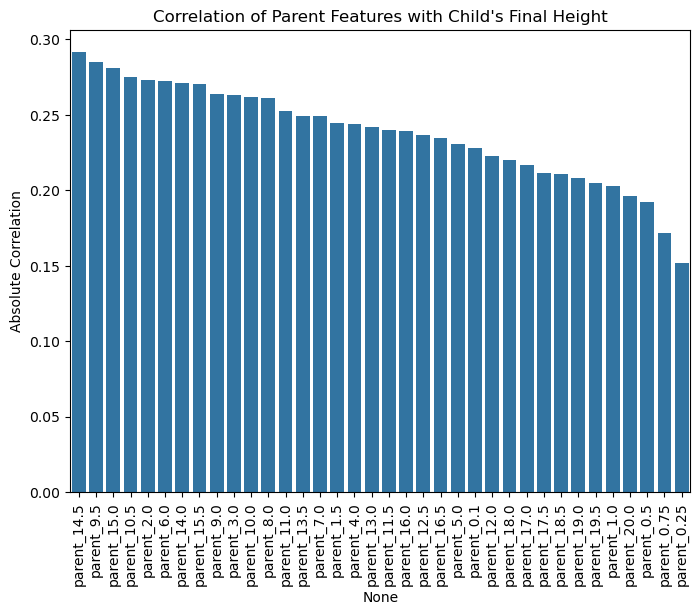

In [34]:
import seaborn as sns
# Compute correlation matrix
corr_matrix = pd.DataFrame(X_train).corrwith(y_train)

# Plot correlation
plt.figure(figsize=(8, 6))
sns.barplot(x=corr_matrix.abs().sort_values(ascending=False).index,
            y=corr_matrix.abs().sort_values(ascending=False))
plt.xticks(rotation=90)
plt.title("Correlation of Parent Features with Child's Final Height")
plt.ylabel("Absolute Correlation")
plt.show()

In [35]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Use a linear regression model for feature selection
model = LinearRegression()
selector = RFE(model, n_features_to_select=6)  # Select top 6 features
selector.fit(X_train, y_train)

# Get selected feature names
selected_features = X_train.columns[selector.support_]
print("Top Features Selected by RFE:", selected_features)

Top Features Selected by RFE: Index(['parent_9.0', 'parent_9.5', 'parent_17.5', 'parent_18.0', 'parent_19.5',
       'parent_20.0'],
      dtype='object')


In [36]:
from sklearn.inspection import permutation_importance

# Train a simple model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Compute permutation importance
perm_importance = permutation_importance(rf_model, X_val, y_val, n_repeats=10, random_state=42)

# Show top features
sorted_idx = np.argsort(perm_importance.importances_mean)[::-1]
for i in sorted_idx[:10]:  # Show top 10
    print(f"{X_train.columns[i]}: {perm_importance.importances_mean[i]:.4f}")

parent_2.0: 0.0351
parent_0.5: 0.0231
parent_6.0: 0.0208
parent_10.5: 0.0132
parent_3.0: 0.0088
parent_0.1: 0.0068
parent_9.5: 0.0057
parent_15.5: 0.0055
parent_14.5: 0.0054
parent_16.5: 0.0052


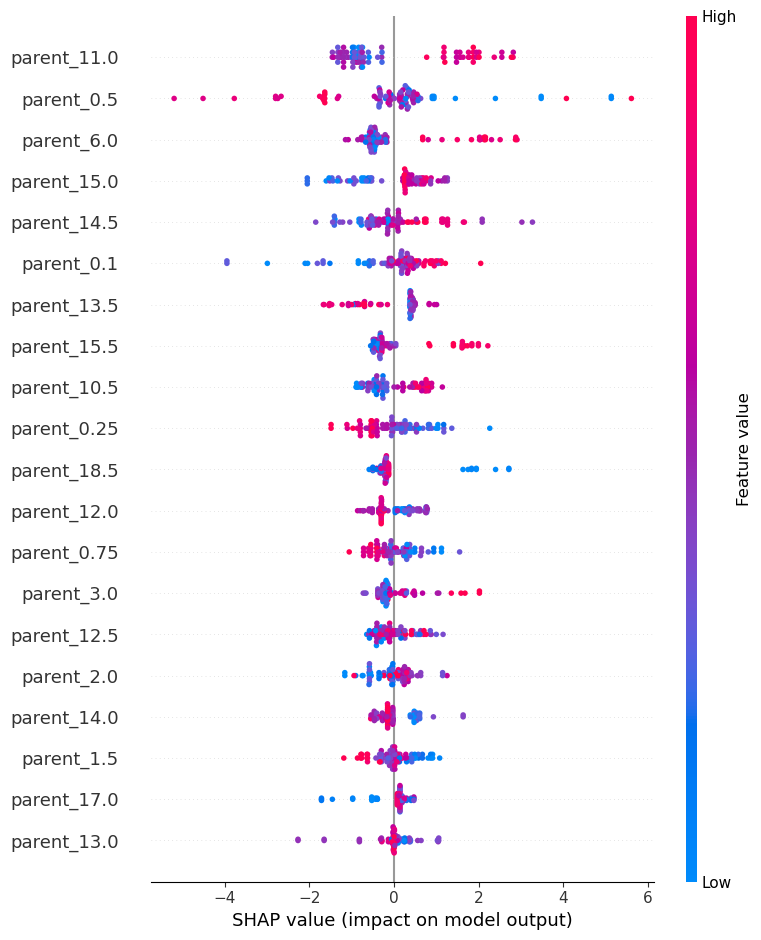

In [39]:
import shap

# Train an XGBoost model
xgb_model = XGBRegressor(n_estimators=500, random_state=42)
xgb_model.fit(X_train, y_train)

# Explain model predictions using SHAP
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_train)

# Plot SHAP summary
shap.summary_plot(shap_values, X_train)

In [40]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Create a dictionary to store feature importance from multiple methods
feature_importance_dict = {}

# 1. Random Forest Importance
rf_importance = rf_model.feature_importances_
feature_importance_dict['RandomForest'] = rf_importance

# 2. XGBoost Importance
xgb_importance = xgb_model.feature_importances_
feature_importance_dict['XGBoost'] = xgb_importance

# 3. Permutation Importance
perm_importance = perm_importance.importances_mean  # Already computed
feature_importance_dict['Permutation'] = perm_importance

# 4. SHAP Values
shap_importance = np.abs(shap_values.values).mean(axis=0)  # Mean absolute SHAP value per feature
feature_importance_dict['SHAP'] = shap_importance

# 5. Pearson Correlation
correlation_importance = X_train.corrwith(y_train).abs().values
feature_importance_dict['Correlation'] = correlation_importance

# 6. RFE Rankings (Lower Rank = More Important)
rfe_rankings = selector.ranking_  # Invert ranking so lower numbers become higher importance
feature_importance_dict['RFE'] = 1 / rfe_rankings  # Invert so smaller ranks have higher scores

# Convert to a DataFrame for easy analysis
feature_importance_df = pd.DataFrame(feature_importance_dict, index=X_train.columns)

# Normalize all values between 0 and 1
scaler = MinMaxScaler()
feature_importance_df_scaled = pd.DataFrame(scaler.fit_transform(feature_importance_df),
                                            columns=feature_importance_df.columns,
                                            index=feature_importance_df.index)

# Compute an average rank across methods
feature_importance_df_scaled["AverageScore"] = feature_importance_df_scaled.mean(axis=1)

# Sort features by highest average importance
feature_importance_df_scaled = feature_importance_df_scaled.sort_values(by="AverageScore", ascending=False)


In [ ]:
feature_importance_df_scaled

,RandomForest,XGBoost,Permutation,SHAP,Correlation,RFE,AverageScore
parent_11.0,0.158757,1.000000,0.481090,1.000000,0.718764,0.021053,0.563277
parent_14.5,0.464110,0.507312,0.649176,0.539269,1.000000,0.095833,0.542617
parent_0.5,1.000000,0.130673,0.858017,0.849402,0.287641,0.006410,0.522024
parent_6.0,0.390746,0.226853,0.831272,0.643727,0.860013,0.060606,0.502203
parent_15.5,0.286732,0.634772,0.650712,0.450159,0.848995,0.008000,0.479895
parent_2.0,0.527658,0.087947,1.000000,0.276287,0.867372,0.046154,0.467570
parent_9.5,0.013204,0.052364,0.652581,0.106536,0.951607,1.000000,0.462715
parent_0.1,0.568718,0.058446,0.666024,0.535638,0.543930,0.225000,0.432959
parent_9.0,0.096698,0.101503,0.394894,0.093792,0.801874,1.000000,0.414794
parent_15.0,0.217335,0.147634,0.545302,0.569561,0.923312,0.009722,0.402144


In [42]:
top_k_features = feature_importance_df_scaled.index[:6]  # Get top 6 features
print("Selected Features:", list(top_k_features))

X_train_selected = X_train[top_k_features]
X_val_selected = X_val[top_k_features]

# Train a new model
rf_model = RandomForestRegressor(n_estimators=500, random_state=42)
rf_model.fit(X_train_selected, y_train)

# Evaluate
y_pred = rf_model.predict(X_val_selected)
mae = mean_absolute_error(y_val, y_pred)
print(f"New Model MAE: {mae:.4f}")

Selected Features: ['parent_11.0', 'parent_14.5', 'parent_0.5', 'parent_6.0', 'parent_15.5', 'parent_2.0']
New Model MAE: 7.0730


In [ ]:
X_train_selected = X_train[top_k_features]
X_val_selected = X_val[top_k_features]

# Train a new model
rf_model = RandomForestRegressor(n_estimators=500, random_state=42)
rf_model.fit(X_train_selected, y_train)

# Evaluate
y_pred = rf_model.predict(X_val_selected)
mae = mean_absolute_error(y_val, y_pred)

print(f"New Model MAE: {mae:.4f}")

New Model MAE: 7.0730


In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np
import pandas as pd

r2_growth = []  # Store R² scores as we add features
selected_features = []  # Track selected features

# Start with an empty feature set and add one feature at a time
for feature in feature_importance_df_scaled.index:
    selected_features.append(feature)

    # Select the current feature subset
    X_train_subset = X_train[selected_features]
    X_val_subset = X_val[selected_features]

    # Train a model (RandomForest)
    model = RandomForestRegressor(n_estimators=500, random_state=42)
    model.fit(X_train_subset, y_train)

    # Make predictions
    y_pred = model.predict(X_val_subset)

    # Compute R² and MAE
    r2 = r2_score(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)

    # Store results
    r2_growth.append({"Num Features": len(selected_features), "R² Score": r2, "MAE": mae, "Features": list(selected_features)})

# Convert results to a DataFrame
r2_growth_df = pd.DataFrame(r2_growth)


In [47]:
r2_growth_df

,Num Features,R² Score,MAE,Features
0,1,0.123795,7.388594,[parent_11.0]
1,2,0.186922,6.999814,"[parent_11.0, parent_14.5]"
2,3,0.196174,7.318008,"[parent_11.0, parent_14.5, parent_0.5]"
3,4,0.204274,7.157820,"[parent_11.0, parent_14.5, parent_0.5, parent_..."
4,5,0.217681,6.998393,"[parent_11.0, parent_14.5, parent_0.5, parent_..."
5,6,0.205492,7.073043,"[parent_11.0, parent_14.5, parent_0.5, parent_..."
6,7,0.197138,7.168841,"[parent_11.0, parent_14.5, parent_0.5, parent_..."
7,8,0.174810,7.285932,"[parent_11.0, parent_14.5, parent_0.5, parent_..."
8,9,0.163086,7.365697,"[parent_11.0, parent_14.5, parent_0.5, parent_..."
9,10,0.165184,7.363066,"[parent_11.0, parent_14.5, parent_0.5, parent_..."


In [50]:
y.describe()

count    111.000000
mean     174.215739
std        8.394207
min      155.483077
25%      168.101932
50%      173.917115
75%      179.792508
max      196.140713
Name: child_18.0, dtype: float64